# Postmating response in axenic and control _D. melanogaster_ females

Load packages and functions:

In [2]:
## Packages to load
req_packages = c("Biobase", "cluster", "cowplot", "cummeRbund", 
                 "data.table", "EDASeq", "edgeR", "ggpubr", 
                 "ggrepel", "ggthemes", "ggthemr", "Glimma", 
                 "GO.db", "goseq", "gplots", "grid", "gridExtra", "lattice", 
                 "imager", "pheatmap", "qvalue", "RColorBrewer", 
                 "reshape", "Rmisc", "RUVSeq","splitstackshape", "statmod", "stringr", "tidyverse",
                 "VennDiagram", "viridis")
## load them, quietly
invisible(suppressWarnings(suppressMessages(lapply(req_packages, require, character.only = TRUE))))

## The Cowplot package changes the default themes of ggplot2. Set the bw theme with larger font sizes like so:
theme_set(theme_bw(base_size = 16))
## ... or set the default theme
# theme_set(theme_gray())

## suppress excessive VennDiagram log files
futile.logger::flog.threshold(futile.logger::ERROR, name = "VennDiagramLogger")

NULL

Load custom functions:

In [3]:
source("Functions.R")

Some raw files need to be processed to produce auxiliary files needed below. Running a script in the "Misc" folder should do it:

In [4]:
# system('./Misc/initial_file_modifications.sh')

Load the FlyAtlas2 expression data:

In [5]:
tpm.table_fa2 = read.csv("Annotoations/FlyAtlas2_TPM_table.txt", header = T, sep = "\t")
tpm.matrix_fa2 = read.csv("Annotoations/FlyAtlas2_meanTPM_table.txt", header = T, sep = "\t", row.names = 1)

... and the associated sample information:

In [6]:
sample.info = read.table("Misc/SraRunTable_FlyAtlas2_modified.txt", header = T, sep = "\t")
sample.info = filter(sample.info, RNA == "mRNA")
sample.info = select(sample.info, Library_Name, Replicate_Name, Sex, dev_stage, organism_part, Sample_Name)
sample.info$Library_Name = gsub("Female ", "", sample.info$Library_Name)
sample.info$Library_Name = gsub("Male ", "", sample.info$Library_Name)
sample.info$Library_Name = gsub("Larval ", "", sample.info$Library_Name)
sample.info$Sex = gsub("NA", "unknown", sample.info$Sex)

Load read count data:

In [7]:
counts_bt2 = read.table("eXpress/express.gene.counts.matrix", header=T, row.names=1, com='', check.names=F)

Load annotation files:

In [8]:
annotation = read.csv("Annotoations/fbgn_annotation_ID_fb_2018_04_mod.tsv", header = T, check.names = F, sep ="\t")

Load the gene snapshot data:

In [9]:
snapshots = read.csv("Annotoations/gene_snapshots_fb_2018_05.tsv", header = T, sep ="\t", quote = "")

Load the Uniprot IDs:

In [10]:
aux_IDs = read.csv("Annotoations/fbgn_auxiliary_ids.txt", header = T, sep ="\t", na.string = "")

Load the GO information:

In [96]:
GO_associations = read.csv("Annotoations/GO_associaations.fb", header = T, sep ="\t")
GO_info = aggregate(term~FBgn_ID, data = GO_associations, toString)
rownames(GO_info) = GO_info$FBgn_ID
GO_info = subset(GO_info, select = "term")
GO_info$term = gsub(", ", ",", GO_info$term)

Load the known immunity genes from Sackton *et al* 2008:

In [12]:
immunity_genes.df = read.csv("Annotoations/mel_immunity_genes.txt", header = T, sep = "\t", check.names = F)
immunity_genes = as.character(immunity_genes.df$FlyBaseID)

Load the transcript lengths for the eXpress data:

In [68]:
bt2_trans_lengths = read.csv("eXpress/transcriptome/transcript_lengths.txt", header = T, sep = "\t")

Load the gene-to-transcript mapping:

In [14]:
gene_trans_map = read.table("eXpress/transcriptome/dmel-all-transcript-r6.23.gene_trans_map", header = F, sep = "\t")
colnames(gene_trans_map) = c("gene_id", "transcript_id")

Generate a gene length object for the eXpress data:

In [82]:
# Merge transcript length file with gene-to-trans file:
tmpMrge = merge(bt2_trans_lengths, gene_trans_map)
# Select only the length and gene_id columns
tmpMrge = as.data.table(subset(tmpMrge, select = c("length", "gene_id")))
# For each gene ID entry, select the entry with largest value in the "length" column:
bt2_gene_lengths = as.data.frame(tmpMrge[tmpMrge[, .I[which.max(length)], by=gene_id]$V1])
# assign gene names to rownames
rownames(bt2_gene_lengths) <- bt2_gene_lengths$gene_id
# # select the length column only
bt2_gene_lengths = subset(bt2_gene_lengths, select = "length")
# remove un-needed intermediate objects
rm(tmpMrge)

For GO analyses we need to create a couple of objects:

In [110]:
GO_info_listed = apply(GO_info, 1, function(x) unlist(strsplit(x,',')))
names(GO_info_listed) = rownames(GO_info)
features_with_GO = rownames(GO_info)
lengths_features_with_GO = bt2_gene_lengths[features_with_GO,]

Generate sample info object:

In [16]:
sampleData = read.table("Misc/samples.txt", header = F, check.names = F, fill = T)
sampleInfo = sampleData
colnames(sampleInfo) = c("Sample", "Replicate")

sampleInfo$Female = ifelse(grepl("^A",sampleInfo$Sample), "axenic", "control")

sampleInfo$Male = ifelse(grepl("A$", sampleInfo$Sample), "axenic", ifelse(grepl("C$", sampleInfo$Sample), "control", "none"))

sampleInfo$Handler = ifelse(grepl("3|4", sampleInfo$Replicate), "Yasir", "Sofie")

sampleInfo$Status = ifelse(grepl("none", sampleInfo$Male), "virgin", "mated")

Generate a TPM table from the counts. Use any arbitrary number for lengths since this is 3prime data:

In [17]:
tpm_bt2 <- apply(counts_bt2, 2, function(x) tpm(x, 2000))

Reshape the TPM matrix to calculate means and generate heatmaps and individual gene plots later:

In [18]:
tmp.tpmMatrix<-tpm_bt2
# colnames(tmp.tpmMatrix) <- sampleInfo$Sample
tmp.tpmMatrix.m <- as.data.frame(melt(as.matrix(tmp.tpmMatrix)))
colnames(tmp.tpmMatrix.m) <- c("gene_id", "replicate", "TPM")
tmp.tpmMatrix.m <- merge(tmp.tpmMatrix.m, sampleInfo, by.x = "replicate", by.y = "Replicate", all.x = T)
tmp.tpmMatrix.m$replicate = gsub(".*_", "", tmp.tpmMatrix.m$replicate)
annot.sub = subset(annotation, select = c("primary_FBgn", "gene_symbol", "annotation_ID"))
tmp.tpmMatrix.m = merge(tmp.tpmMatrix.m, annot.sub, by.x = "gene_id", by.y = "primary_FBgn", all.x = T)
# tmp.tpmMatrix.m = merge
tpm.table = tmp.tpmMatrix.m
tpm.table$Male = factor(tpm.table$Male, levels = c("none", "axenic", "control"))
tpm.table$Status = factor(tpm.table$Status, levels = c("virgin", "mated"))
rm(tmp.tpmMatrix.m)

the `geneBoxPlot` function can be used for single gene tpm boxplots of the data:

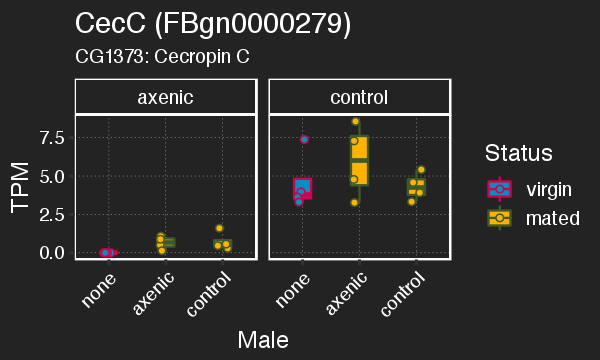

In [19]:
options(repr.plot.width = 5, repr.plot.height = 3)
geneBoxPlot_mon("CecC", show_reps = F) + theme_monokai_full() + theme(axis.text.x = element_text(angle = 45, hjust = 1))

There's also a plotting function for the Fly Atlas data:

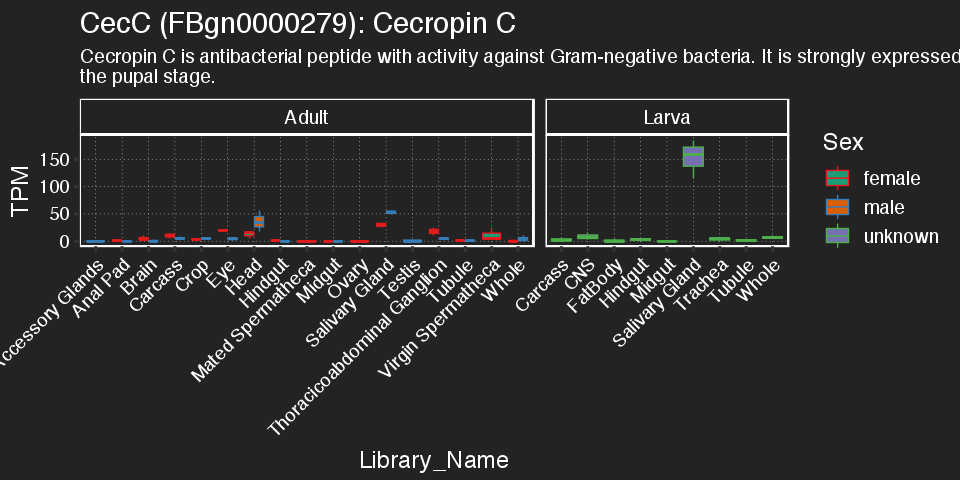

In [20]:
options(repr.plot.width = 8, repr.plot.height = 4)
geneBoxPlot_fa2(tpm.table_fa2, "CecC")

For heatmaps, we can make some modifications to the output format:

In [21]:
draw_colnames_45 <- function (coln, gaps, ...) {
    coord <- pheatmap:::find_coordinates(length(coln), gaps)
    x     <- coord$coord - 0.5 * coord$size
    res   <- grid::textGrob(
      coln, x = x, y = unit(1, "npc") - unit(3,"bigpts"),
      vjust = 0.75, hjust = 1, rot = 45, gp = grid::gpar(...)
    )
    return(res)
}
assignInNamespace(
  x = "draw_colnames",
  value = "draw_colnames_45",
  ns = asNamespace("pheatmap")
)

Output library size object:

In [22]:
LibSizes <- as.data.frame(colSums(counts_bt2))
libSizes <- cbind(sample = row.names(LibSizes), LibSizes)
row.names(libSizes)<- NULL
colnames(libSizes) = c("replicate", "counts")
libSizes$sample = gsub("_.*", "", libSizes$replicate)

Make a barplot of library sizes:

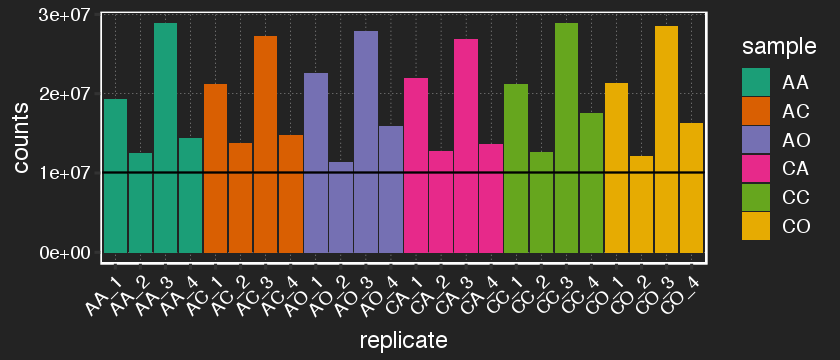

In [23]:
options(repr.plot.width = 7, repr.plot.height = 3)
# pdf("Figures/Library_sizes.pdf", width = 12, height = 4)
ggplot(libSizes, aes(replicate, counts, fill = sample)) + 
    geom_bar(stat="identity", position = "dodge") + 
    theme_monokai_full() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) + 
    geom_hline(yintercept = 10000000) +
    scale_fill_brewer(palette="Dark2") 
# dev.off()

### Differential expression analysis (eXpress):

First, filter out genes with very low expression from the counts matrix. We'll use a minimum cutoff of 1 CPM in at least 4 samples:

In [24]:
# counts_bt2 = subset(counts_bt2, rownames(counts_bt2) %!in% wierd_genes)
cpm_bt2 <- cpm(counts_bt2)
thresh_bt2 <- cpm_bt2 > 1
keep_bt2 <- rowSums(thresh_bt2) >= 4
countsKeep_bt2 <- counts_bt2[keep_bt2,]
# countsKeep_bt2 <- subset(countsKeep_bt2, rownames(countsKeep_bt2) %!in% wierd_genes)
table(keep_bt2)

keep_bt2
FALSE  TRUE 
 6282  7649 

Now define the groupings by sample and set up the design matrix:

In [25]:
groups = factor(sampleInfo$Sample)
batch = factor(sampleInfo$Handler)
design_batch = model.matrix( ~ 0 + groups + batch)
colnames(design_batch) <- c(levels(groups), "batch")
rownames(design_batch) <- sampleInfo$Replicate

Create the DGElist object and GLM fit:

In [26]:
dgeList_batch <- DGEList(counts = countsKeep_bt2, group = groups)
dgeList_batch <- calcNormFactors(dgeList_batch)
dgeList_batch <- estimateGLMCommonDisp(dgeList_batch, design_batch)
dgeList_batch <- estimateGLMTagwiseDisp(dgeList_batch, design_batch)
dgeList_batch_fit <- glmQLFit(dgeList_batch, design_batch)
summary(dgeList_batch$tagwise.dispersion)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.01717 0.03454 0.04560 0.06829 0.07082 3.09565 

We'll make an FBgn-to-gene symbol object to append to the tTags tables:

In [27]:
FBgn_to_symbol = subset(annotation, select = c("gene_symbol", "primary_FBgn"))

Make a separate DGElist object for the batch fit:

In [28]:
dgeList = dgeList_batch
dgeList_fit = dgeList_batch_fit

Look at BCV and QQ plot:

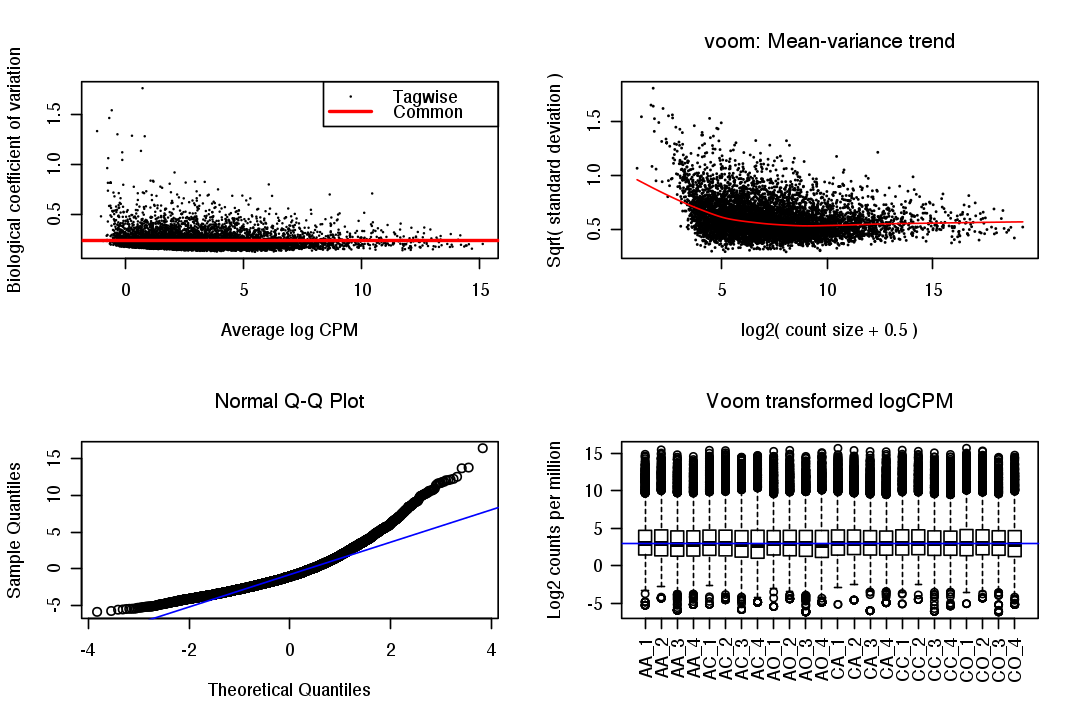

In [29]:
options(repr.plot.width = 9, repr.plot.height = 6)
par(mfrow=c(2,2))
# Biological coefficient of variation
plotBCV(dgeList)
# mean-variance trend
voom = voom(dgeList, design_batch, plot=TRUE)
# QQ-plot
g.v <- gof(dgeList_fit)
z.v <- zscoreGamma(g.v$gof.statistics,shape=g.v$df/2,scale=2)
qqnorm(z.v); qqline(z.v, col = 4,lwd=1,lty=1)
# log2 transformed and normalize boxplot of counts across samples
boxplot(voom$E, xlab="", ylab="Log2 counts per million",las=2,main="Voom transformed logCPM")
abline(h=median(voom$E),col="blue")

rm(voom, g.v, z.v)


Generate a correlation plot between replicates:

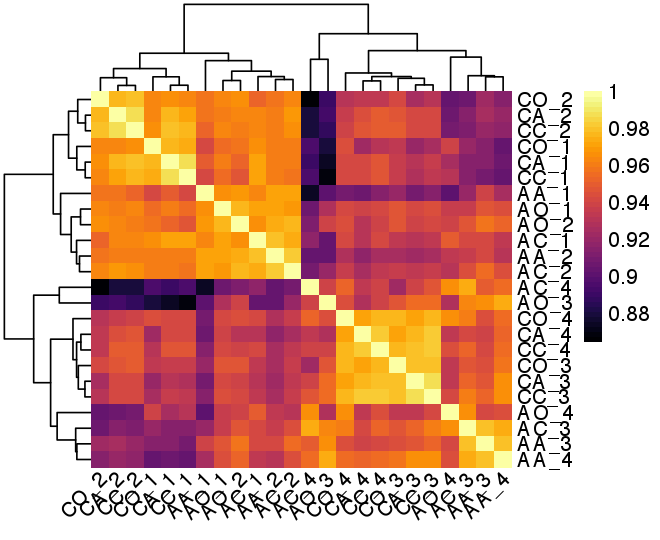

In [30]:
## Plot sample correlation
data = log2(countsKeep_bt2+1)
# colnames(data) = gsub("Female_", "", colnames(data))
data = as.matrix(data)
sample_cor = cor(data, method='pearson', use='pairwise.complete.obs')

options(repr.plot.width = 5.5, repr.plot.height = 4.5)
pheatmap(
  mat               = sample_cor,
  color             = inferno(50),
  border_color      = NA,
  show_colnames     = TRUE,
  show_rownames     = TRUE,
#   filename          = "Figures/sample_correlations_all.pdf",
#   width             = 6, 
#   height            = 5,
  fontsize          = 12    
)
rm(data)
rm(sample_cor)

Hmmmm.... wierd groupings by replicate. Look at an MDS plot:

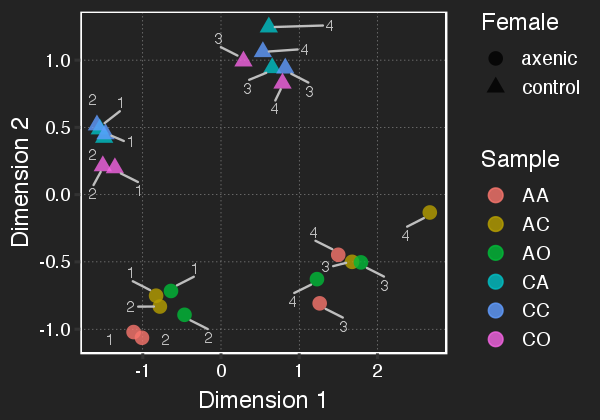

In [31]:
options(repr.plot.width = 5, repr.plot.height = 3.5)
c.mds.gg(dgeList) + theme_monokai_full() + theme(axis.text.x = element_text(angle = 0))

We'll identify the genes that are causing the batch between 1-2 and 3-4. 

In [32]:
# add a column specifying the sample batch grouping
sampleInfo2 = sampleInfo
sampleInfo2$repGroup = paste(sampleInfo2$Sample, sampleInfo2$Handler, sep = ".")
# set up design matrix for this comparison
repGroups = factor(sampleInfo2$repGroup)
design_reps = model.matrix( ~ 0 + repGroups)
colnames(design_reps) <- levels(repGroups)
rownames(design_reps) <- sampleInfo$Replicate

## Now make the DGE object:
dgeList_rG <- DGEList(counts = countsKeep_bt2, group = repGroups)
dgeList_rG <- calcNormFactors(dgeList_rG)
dgeList_rG <- estimateGLMCommonDisp(dgeList_rG, design_reps)
dgeList_rG <- estimateGLMTagwiseDisp(dgeList_rG, design_reps)
dgeList_rG_fit <- glmQLFit(dgeList_rG, design_reps)
summary(dgeList_rG$tagwise.dispersion)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.02250 0.04003 0.05093 0.06989 0.07450 2.22087 

Now we'll make the desired contrasts between handler's for each sample group:

In [33]:
AO_contrasts <- makeContrasts(AO.Sofie-AO.Yasir, levels=design_reps)
AA_contrasts <- makeContrasts(AA.Sofie-AA.Yasir, levels=design_reps)
AC_contrasts <- makeContrasts(AC.Sofie-AC.Yasir, levels=design_reps)

CO_contrasts <- makeContrasts(CO.Sofie-CO.Yasir, levels=design_reps)
CA_contrasts <- makeContrasts(CA.Sofie-CA.Yasir, levels=design_reps)
CC_contrasts <- makeContrasts(CC.Sofie-CC.Yasir, levels=design_reps)

Run the DE test and make lists of significant genes for each contrast:

In [34]:
# run the LRT and extract the DE table
lrt.AO.table <- edge.DE(dgeList_rG_fit, AO_contrasts)
AO_sigGenes = subset(lrt.AO.table, sig == "yes")$gene

lrt.AA.table <- edge.DE(dgeList_rG_fit, AA_contrasts)
AA_sigGenes = subset(lrt.AA.table, sig == "yes")$gene

lrt.AC.table <- edge.DE(dgeList_rG_fit, AC_contrasts)
AC_sigGenes = subset(lrt.AC.table, sig == "yes")$gene

lrt.CO.table <- edge.DE(dgeList_rG_fit, CO_contrasts)
CO_sigGenes = subset(lrt.CO.table, sig == "yes")$gene

lrt.CA.table <- edge.DE(dgeList_rG_fit, CA_contrasts)
CA_sigGenes = subset(lrt.CA.table, sig == "yes")$gene

lrt.CC.table <- edge.DE(dgeList_rG_fit, CC_contrasts)
CC_sigGenes = subset(lrt.CC.table, sig == "yes")$gene

We can look at volcano plots of DE genes:

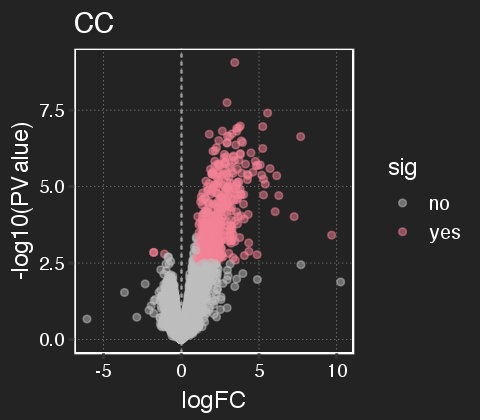

In [35]:
options(repr.plot.width = 4, repr.plot.height = 3.5)
edge.DE.gg(lrt.CC.table) +
    scale_colour_manual(values = c("gray","#f38195")) +
    labs(title = "CC", size = 2) +
    theme_monokai_full() + theme(axis.text.x = element_text(angle = 0))

We can use Venn diagrams or output a summary of the overlaps:

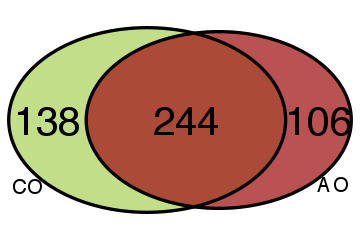

In [36]:
virgin_candidates <- list(AO = AO_sigGenes, 
                        CO = AA_sigGenes)

virgin_Vdiag<-venn.diagram(virgin_candidates, NULL, fill=c("#a3181b", "#afd360"), alpha=c(0.75,0.75), cex = 2, cat.fontface= 6, cat.cex = 1, resolution = 100, )

virgin_combs <- unlist(lapply(1:length(virgin_candidates), function(j) combn(names(virgin_candidates), j, simplify = FALSE)), recursive = FALSE)
names(virgin_combs) <- sapply(virgin_combs, function(i) paste0(i, collapse = ","))
virgin_elements <- lapply(virgin_combs, function(i) Setdiff(virgin_candidates[i], virgin_candidates[setdiff(names(virgin_candidates), i)]))
options(repr.plot.width = 3, repr.plot.height =2)
# summary(virgin_elements)
grid.arrange(gTree(children=virgin_Vdiag))
rm(virgin_candidates, virgin_Vdiag, virgin_combs)

Now back to the analysis. We'll set up all the relevant contrasts:

In [37]:
# pairwise contrasts
virgin_contrasts <- makeContrasts(CO-AO, levels=design_batch)
AA.v.AO_contrasts <- makeContrasts(AA-AO, levels=design_batch)
AC.v.AO_contrasts <- makeContrasts(AC-AO, levels=design_batch)
CA.v.CO_contrasts <- makeContrasts(CA-CO, levels=design_batch)
CC.v.CO_contrasts <- makeContrasts(CC-CO, levels=design_batch)

# male effect
male.effect.A.background <- makeContrasts( AA-AC, levels = design_batch)
male.effect.C.background <- makeContrasts( CA-CC, levels = design_batch)

# female effect:
A.female.effect <- makeContrasts( ((AA-AO)+(AC-AO))/2 - ((CA-CO)+(CC-CO))/2, levels = design_batch)
A.male.effect <- makeContrasts( ((AA-AO)+(CA-CO))/2 - ((CC-CO)+(AC-AO))/2, levels = design_batch)

# mated female effect:
AA.effect <- makeContrasts( (AA-AO) - ((AC-AO)+(CC-CO)+(CA-CO))/3, levels=design_batch)
AC.effect <- makeContrasts( (AC-AO) - ((AA-AO)+(CC-CO)+(CA-CO))/3, levels=design_batch)
CA.effect <- makeContrasts( (CA-CO) - ((AC-AO)+(CC-CO)+(AA-AO))/3, levels=design_batch)
CC.effect <- makeContrasts( (CC-CO) - ((AC-AO)+(AA-AO)+(CA-CO))/3, levels=design_batch)

##### Virgin female contrasts (axenic vs. control):

First look at the difference between the axenic and control virgin samples:

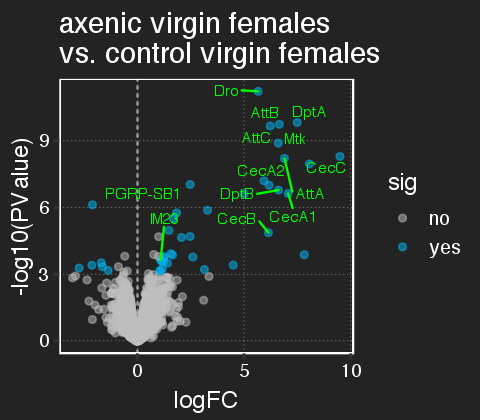

In [38]:
# run the LRT and extract the DE table
lrt.virgins.table <- edge.DE(dgeList_fit, virgin_contrasts, LRT = F)
lrt.virgins.table <- subset(lrt.virgins.table, gene %!in% c(AO_sigGenes, CO_sigGenes))
virgins_sigGenes = subset(lrt.virgins.table, sig == "yes" & gene %!in% c(AO_sigGenes, CO_sigGenes))$gene
virgins_sigGenes_up = subset(lrt.virgins.table, sig == "yes" & gene %!in% c(AO_sigGenes, CO_sigGenes) & logFC > 1)$gene
virgins_sigGenes_down = subset(lrt.virgins.table, sig == "yes" & gene %!in% c(AO_sigGenes, CO_sigGenes) & logFC < -1)$gene

options(repr.plot.width = 4, repr.plot.height = 3.5)
# pdf("Figures/virgin_female_contrast.pdf", width = 4, height = 3.5)
(virgin_contrasts_volcano.gg = edge.DE.gg(lrt.virgins.table) +
                                scale_colour_manual(values = c("gray","#00b6f3")) +
                                geom_text_repel(data = filter(lrt.virgins.table, sig == "yes" & gene %in% immunity_genes),aes(label=gene_symbol), 
                                force = 30,
                                colour = "green",
                                fontface = "bold", 
                                size = 3,
                                ylim = c(5, NA)) +
                                labs(title = "axenic virgin females \nvs. control virgin females", size = 2) +
                                theme_monokai_full() + theme(axis.text.x = element_text(angle = 0)))
# dev.off()

Look at a heatmap of these results

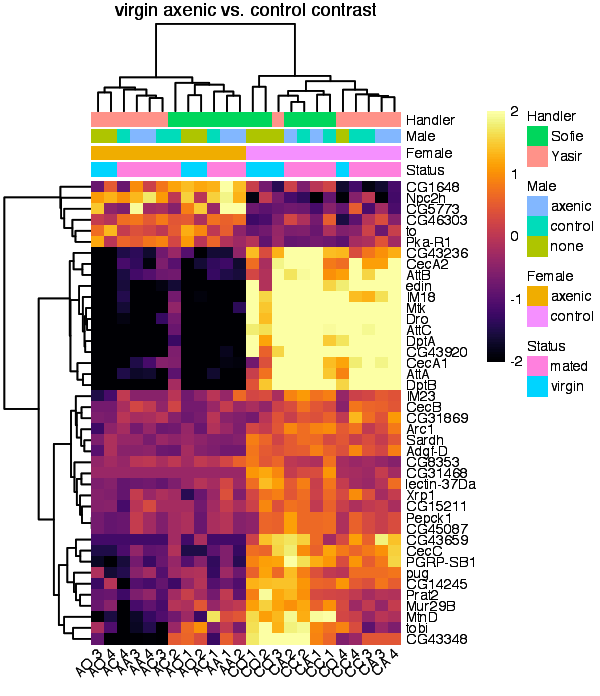

In [39]:
options(repr.plot.width = 5, repr.plot.height = 5.8)

heatmap_fa2(tpm_bt2, virgins_sigGenes, fly_atlas = F, title = "virgin axenic vs. control contrast")

These plots show that the majority of DE genes are are immune related, and all but two are antimicrobial peptides. We can list those here:

In [40]:
subset(immunity_genes.df, FlyBaseID %in% virgins_sigGenes)

,FlyBaseID,Symbol,Name,Synonyms,Chr,Cyto,Functional Class,Notes
7,FBgn0012042,AttA,Attacin-A,.,2R,51C1,effector,antimicrobial peptide
8,FBgn0041581,AttB,Attacin-B,.,2R,51C1,effector,antimicrobial peptide
9,FBgn0041579,AttC,Attacin-C,.,2R,50A3,effector,antimicrobial peptide
19,FBgn0000276,CecA1,Cecropin A1,.,3R,99E2,effector,antimicrobial peptide
20,FBgn0000277,CecA2,Cecropin A2,.,3R,99E2,effector,antimicrobial peptide
21,FBgn0000278,CecB,Cecropin B,.,3R,99E2,effector,antimicrobial peptide
22,FBgn0000279,CecC,Cecropin C,.,3R,99E2,effector,antimicrobial peptide
69,FBgn0004240,Dpt,Diptericin,.,2R,55F8,effector,antimicrobial peptide
70,FBgn0034407,DptB,Diptericin B,.,2R,55F8,effector,antimicrobial peptide
72,FBgn0010388,Dro,Drosocin,.,2R,51C1,effector,antimicrobial peptide


These are most of the antimicrobial peptides, with only the several Drosomycins and Defensin missing. A quick look at the GO results:

Using manually entered categories.
Calculating the p-values...
'select()' returned 1:1 mapping between keys and columns


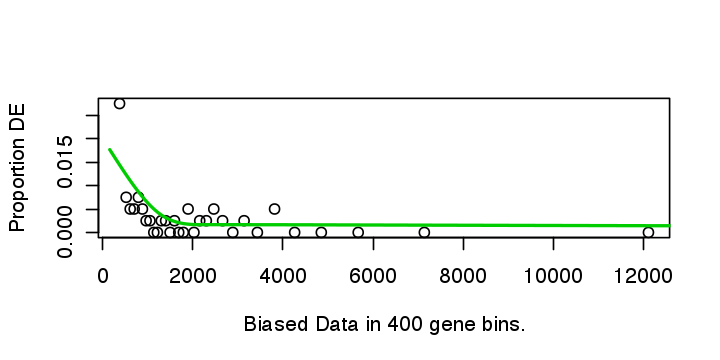

In [121]:
# build pwf based on ALL DE features
options(repr.plot.width = 6, repr.plot.height = 3)
cat_genes_vec = as.integer(features_with_GO %in% virgins_sigGenes)
pwf=nullp(DEgenes = cat_genes_vec, bias.data=lengths_features_with_GO)
rownames(pwf) = names(GO_info_listed)
pwf$DEgenes = cat_genes_vec
res = goseq(pwf,gene2cat=GO_info_listed)

In [122]:
## over-represented categories:
pvals = res$over_represented_pvalue
pvals[pvals > 1 -1e-10] = 1-1e-10
q = qvalue(pvals)
res$over_represented_FDR = q$qvalues
virgins_sigGenes_enrich_result_table = res[res$over_represented_pvalue<=0.05,]
subset(virgins_sigGenes_enrich_result_table, over_represented_FDR < 0.05)

,category,over_represented_pvalue,under_represented_pvalue,numDEInCat,numInCat,term,ontology,over_represented_FDR
1921,GO:0006959,0.000000e+00,1.0000000,9,25,humoral immune response,BP,0.000000e+00
3669,GO:0019731,0.000000e+00,1.0000000,11,22,antibacterial humoral response,BP,0.000000e+00
6354,GO:0050830,0.000000e+00,1.0000000,12,56,defense response to Gram-positive bacterium,BP,0.000000e+00
6353,GO:0050829,8.263402e-11,1.0000000,9,113,defense response to Gram-negative bacterium,BP,1.653920e-07
1262,GO:0005576,1.274382e-10,1.0000000,15,451,extracellular region,CC,2.040540e-07
2784,GO:0009617,6.197495e-09,1.0000000,7,45,response to bacterium,BP,8.269524e-06
1266,GO:0005615,2.357204e-06,0.9999997,12,554,extracellular space,CC,2.695967e-03
5336,GO:0042742,4.875482e-06,0.9999998,5,62,defense response to bacterium,BP,4.879138e-03
2704,GO:0009113,7.937027e-06,1.0000000,2,4,purine nucleobase biosynthetic process,BP,7.060427e-03
1919,GO:0006952,1.125511e-05,0.9999997,4,32,defense response,BP,9.010843e-03


We can look at the expression of individual genes across all our samples:

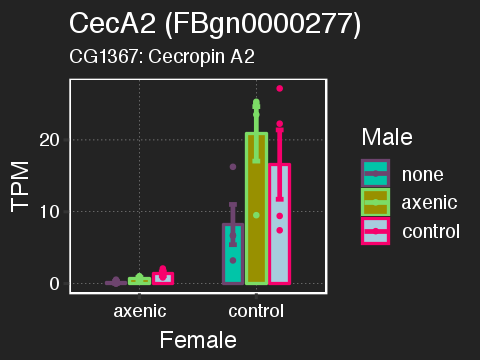

In [41]:
options(repr.plot.width = 4, repr.plot.height = 3)
geneBarPlot_mon(gene = "CecA2", show_reps = T) + theme_monokai_full()

With boxplots we can look at either axenic or control female samples only, in case the differences are masked by high expression in one of the female treatments:

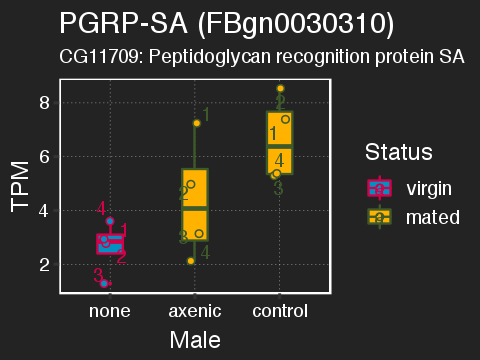

In [42]:
options(repr.plot.width = 4, repr.plot.height = 3)
geneBoxPlot_mon_byFemale("PGRP-SA", "axenic", show_reps = T) + theme_monokai_full()

Output individual gene plots for closer interrogation:

In [43]:
virgins_sigGenes.Plots = suppressMessages(lapply(virgins_sigGenes, geneBoxPlot, show_reps = T))
ggsave("Results/Figures/virgins_sigGenes.Plots.pdf", marrangeGrob(grobs = virgins_sigGenes.Plots, nrow = 2, ncol =2))

Saving 7 x 7 in image


And output snapshot summary:

In [44]:
tempInfo = filter(snapshots, FBgn_ID %in% virgins_sigGenes)
tempInfo = select(tempInfo, -datestamp)
write.table(tempInfo, "Results/Tables/virgins_sigGenes_snapshots.txt", quote = F, sep = "\t", row.names = F)

##### Contrast between virgin and mated axenic females:

Now compare the mated axenic females to virgin axenic females. First, females mated to axenic males

In [45]:
# run the LRT and extract the DE table
lrt.AA.v.AO.table <- edge.DE(dgeList_fit, AA.v.AO_contrasts)
lrt.AA.v.AO.table <- subset(lrt.AA.v.AO.table, gene %!in% c(AA_sigGenes, AO_sigGenes))
AA.v.AO_sigGenes = subset(lrt.AA.v.AO.table, sig == "yes" & gene %!in% c(AA_sigGenes, AO_sigGenes))$gene
AA.v.AO_sigGenes_up = subset(lrt.AA.v.AO.table, sig == "yes" & gene %!in% c(AA_sigGenes, AO_sigGenes) & logFC > 1)$gene
AA.v.AO_sigGenes_down = subset(lrt.AA.v.AO.table, sig == "yes" & gene %!in% c(AA_sigGenes, AO_sigGenes) & logFC < -1)$gene

options(repr.plot.width = 4, repr.plot.height = 3.5)
AA.v.AO_contrasts_volcano.gg = edge.DE.gg(lrt.AA.v.AO.table) +
                                scale_colour_manual(values = c("gray","#33ed5a")) +
                                geom_text_repel(data = filter(lrt.AA.v.AO.table, sig == "yes" & gene %in% immunity_genes),aes(label=gene_symbol), 
                                force = 10,
                                fontface = "bold", 
                                size = 3,
                                colour = "#0094ea",
                                ylim = c(6, NA)) +
                                labs(title = "axenic females X axenic males\nvs. axenic virgin females", size = 2) +
                                theme_monokai_full() + theme(axis.text.x = element_text(angle = 0))

... and females mated to control males

In [46]:
# run the LRT and extract the DE table
lrt.AC.v.AO.table <- edge.DE(dgeList_fit, AC.v.AO_contrasts)
lrt.AC.v.AO.table <- subset(lrt.AC.v.AO.table, gene %!in% c(AC_sigGenes, AO_sigGenes))
AC.v.AO_sigGenes = subset(lrt.AC.v.AO.table, sig == "yes" & gene %!in% c(AC_sigGenes, AO_sigGenes))$gene
AC.v.AO_sigGenes_up = subset(lrt.AC.v.AO.table, sig == "yes" & gene %!in% c(AC_sigGenes, AO_sigGenes) & logFC > 1)$gene
AC.v.AO_sigGenes_down = subset(lrt.AC.v.AO.table, sig == "yes" & gene %!in% c(AC_sigGenes, AO_sigGenes) & logFC < -1)$gene

options(repr.plot.width = 4, repr.plot.height = 3.5)
AC.v.AO_contrasts_volcano.gg = edge.DE.gg(lrt.AC.v.AO.table) +
                                scale_colour_manual(values = c("gray","#33ed5a")) +
                                geom_text_repel(data = filter(lrt.AC.v.AO.table, sig == "yes" & gene %in% immunity_genes),aes(label=gene_symbol), 
                                force = 10,
                                fontface = "bold", 
                                size = 3,
                                colour = "#0094ea",
                                ylim = c(6, NA)) +
                                labs(title = "axenic females X control males\nvs. axenic virgin females", size = 2) +
                                theme_monokai_full() + theme(axis.text.x = element_text(angle = 0))

Show those volcano plots:

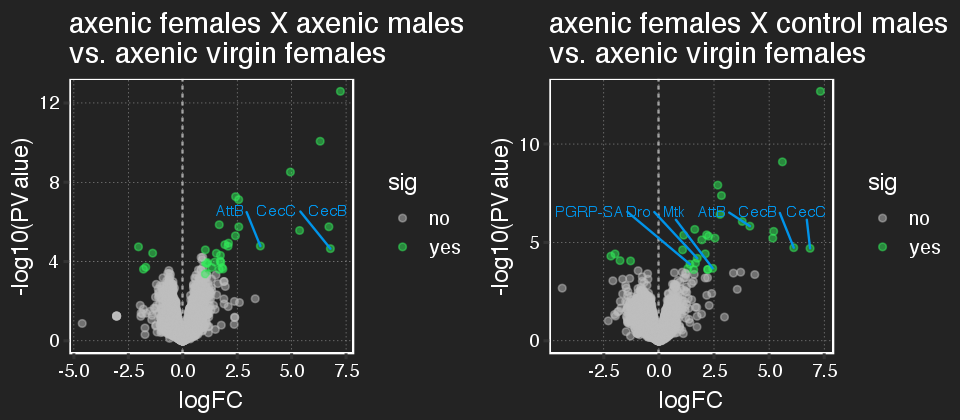

In [47]:
options(repr.plot.width = 8, repr.plot.height = 3.5)
# pdf("Figures/mated_axenic_female_contrasts.pdf", width = 8, height = 3.5)
plot_grid(AA.v.AO_contrasts_volcano.gg, AC.v.AO_contrasts_volcano.gg, ncol = 2)
# dev.off()

Here're heatmaps of those results:

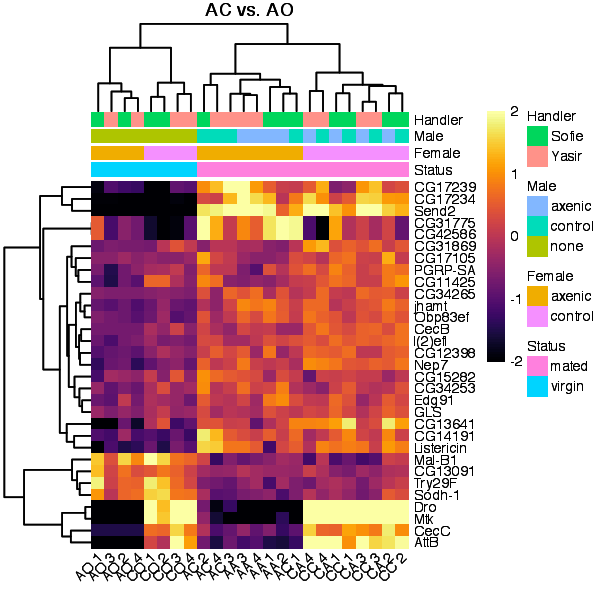

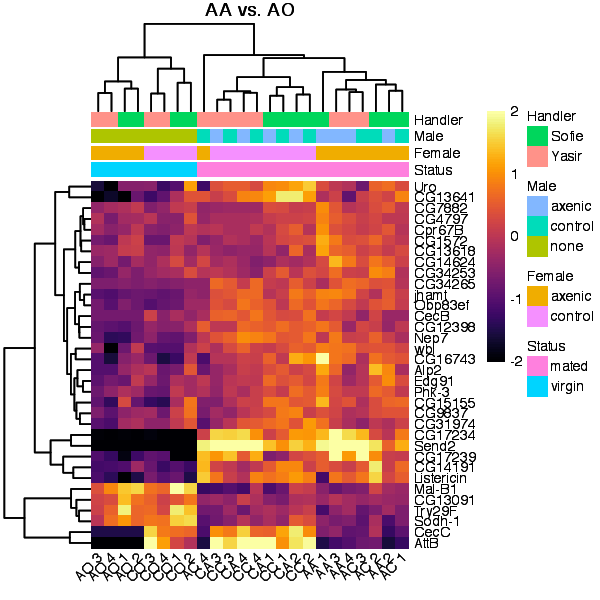

In [48]:
options(repr.plot.width = 5, repr.plot.height = 5)
heatmap_fa2(tpm_bt2, AC.v.AO_sigGenes, fly_atlas = F, title = "AC vs. AO")
heatmap_fa2(tpm_bt2, AA.v.AO_sigGenes, fly_atlas = F, title = "AA vs. AO")

We can now directly look at the overlap between the two contrasts:

                Length Class  Mode     
AC.v.AO         11     -none- character
AA.v.AO         14     -none- character
AC.v.AO,AA.v.AO 20     -none- character

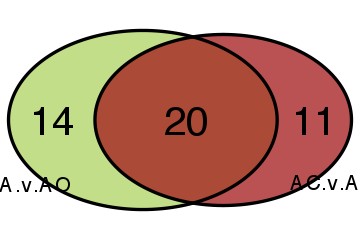

In [86]:
AAxAO.v.ACxAO_candidates <- list(AC.v.AO = AC.v.AO_sigGenes, 
                        AA.v.AO = AA.v.AO_sigGenes)

AAxAO.v.ACxAO_Vdiag<-venn.diagram(AAxAO.v.ACxAO_candidates, NULL, fill=c("#a3181b", "#afd360"), alpha=c(0.75,0.75), cex = 2, cat.fontface= 6, cat.cex = 1, resolution = 100, )

AAxAO.v.ACxAO_combs <- unlist(lapply(1:length(AAxAO.v.ACxAO_candidates), function(j) combn(names(AAxAO.v.ACxAO_candidates), j, simplify = FALSE)), recursive = FALSE)
names(AAxAO.v.ACxAO_combs) <- sapply(AAxAO.v.ACxAO_combs, function(i) paste0(i, collapse = ","))
AAxAO.v.ACxAO_elements <- lapply(AAxAO.v.ACxAO_combs, function(i) Setdiff(AAxAO.v.ACxAO_candidates[i], AAxAO.v.ACxAO_candidates[setdiff(names(AAxAO.v.ACxAO_candidates), i)]))
options(repr.plot.width = 3, repr.plot.height =2)
grid.arrange(gTree(children=AAxAO.v.ACxAO_Vdiag))
summary(AAxAO.v.ACxAO_elements)
rm(AAxAO.v.ACxAO_candidates, AAxAO.v.ACxAO_Vdiag, AAxAO.v.ACxAO_combs)

20 gene respond similarly to mating regardless of male genotype, but 11 and 14 are unique to the AC and AA comparisons, respectively. For closer scrutiny we'll generate plots of individual genes:

In [50]:
tmp.Plots = suppressMessages(lapply(AAxAO.v.ACxAO_elements$`AC.v.AO,AA.v.AO`, geneBoxPlot_mon_byFemale, "axenic", show_reps = T))
ggsave("Results/Figures/AAxAO.v.ACxAO_elements_sigIn_sahred.Plots.pdf", marrangeGrob(grobs = tmp.Plots, nrow = 2, ncol =2))

tmp.Plots = suppressMessages(lapply(AAxAO.v.ACxAO_elements$AC.v.AO, geneBoxPlot_mon_byFemale, "axenic", show_reps = T))
ggsave("Results/Figures/AAxAO.v.ACxAO_elements_sigIn_AC.v.AO.Plots.pdf", marrangeGrob(grobs = tmp.Plots, nrow = 2, ncol =2))

tmp.Plots = suppressMessages(lapply(AAxAO.v.ACxAO_elements$AA.v.AO, geneBoxPlot_mon_byFemale, "axenic", show_reps = T))
ggsave("Results/Figures/AAxAO.v.ACxAO_elements_sigIn_AA.v.AO.Plots.pdf", marrangeGrob(grobs = tmp.Plots, nrow = 2, ncol =2))

rm(tmp.Plots)

Saving 7 x 7 in image
Saving 7 x 7 in image
Saving 7 x 7 in image


Run a GO analysis on the set of DE genes:

Set up null objects:

Using manually entered categories.
Calculating the p-values...
'select()' returned 1:1 mapping between keys and columns


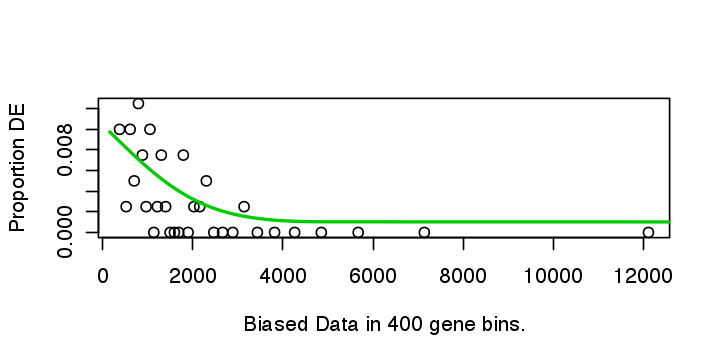

In [114]:
# build pwf based on ALL DE features
options(repr.plot.width = 6, repr.plot.height = 3)
cat_genes_vec = as.integer(features_with_GO %in% unlist(AAxAO.v.ACxAO_elements))
pwf=nullp(DEgenes = cat_genes_vec, bias.data=lengths_features_with_GO)
rownames(pwf) = names(GO_info_listed)
pwf$DEgenes = cat_genes_vec
res = goseq(pwf,gene2cat=GO_info_listed)

Run the multiple test correction and extract significant terms

In [119]:
## over-represented categories:
pvals = res$over_represented_pvalue
pvals[pvals > 1 -1e-10] = 1-1e-10
q = qvalue(pvals)
res$over_represented_FDR = q$qvalues
AAxAO.v.ACxAO_enrich_result_table = res[res$over_represented_pvalue<=0.05,]
subset(AAxAO.v.ACxAO_enrich_result_table, over_represented_FDR < 0.05)

,category,over_represented_pvalue,under_represented_pvalue,numDEInCat,numInCat,term,ontology,over_represented_FDR
6354,GO:0050830,1.300481e-09,1.0000000,7,56,defense response to Gram-positive bacterium,BP,1.041165e-05
3669,GO:0019731,2.565863e-08,1.0000000,5,22,antibacterial humoral response,BP,1.027115e-04
6353,GO:0050829,1.318163e-05,0.9999994,5,113,defense response to Gram-negative bacterium,BP,3.517736e-02


##### Contrast between virgin and mated control females:

Now let's look at the control females. First, females mated to axenic males

In [123]:
# run the LRT and extract the DE table
lrt.CA.v.CO.table <- edge.DE(dgeList_fit, CA.v.CO_contrasts)
lrt.CA.v.CO.table <- subset(lrt.CA.v.CO.table, gene %!in% c(CA_sigGenes, CO_sigGenes))
CA.v.CO_sigGenes = subset(lrt.CA.v.CO.table, sig == "yes" & gene %!in% c(CA_sigGenes, CO_sigGenes))$gene
CA.v.CO_sigGenes_up = subset(lrt.CA.v.CO.table, sig == "yes" & gene %!in% c(CA_sigGenes, CO_sigGenes) & logFC > 1)$gene
CA.v.CO_sigGenes_down = subset(lrt.CA.v.CO.table, sig == "yes" & gene %!in% c(CA_sigGenes, CO_sigGenes) & logFC < -1)$gene

options(repr.plot.width = 4, repr.plot.height = 3.5)
CA.v.CO_contrasts_volcano.gg = edge.DE.gg(lrt.CA.v.CO.table) +
                                scale_colour_manual(values = c("gray","#f38195")) +
                                geom_text_repel(data = filter(lrt.CA.v.CO.table, sig == "yes" & gene %in% immunity_genes),aes(label=gene_symbol), 
                                force = 10,
                                fontface = "bold", 
                                size = 3,
                                colour = "#5dc6f5") +
                                labs(title = "control females X axenic males\nvs. control virgin females", size = 2) +
                                theme_monokai_full() + theme(axis.text.x = element_text(angle = 0))

... and females mated to control males

In [125]:
# run the LRT and extract the DE table
lrt.CC.v.CO.table <- edge.DE(dgeList_fit, CC.v.CO_contrasts)
lrt.CC.v.CO.table <- subset(lrt.CC.v.CO.table, gene %!in% c(CC_sigGenes, CO_sigGenes))
CC.v.CO_sigGenes = subset(lrt.CC.v.CO.table, sig == "yes" & gene %!in% c(CC_sigGenes, CO_sigGenes))$gene
CC.v.CO_sigGenes_up = subset(lrt.CC.v.CO.table, sig == "yes" & gene %!in% c(CA_sigGenes, CO_sigGenes) & logFC > 1)$gene
CC.v.CO_sigGenes_down = subset(lrt.CC.v.CO.table, sig == "yes" & gene %!in% c(CA_sigGenes, CO_sigGenes) & logFC < -1)$gene

options(repr.plot.width = 4, repr.plot.height = 3.5)
CC.v.CO_contrasts_volcano.gg = edge.DE.gg(lrt.CC.v.CO.table) +
                                scale_colour_manual(values = c("gray","#f38195")) +
                                geom_text_repel(data = filter(lrt.CC.v.CO.table, sig == "yes" & gene %in% immunity_genes),aes(label=gene_symbol), 
                                force = 10,
                                fontface = "bold", 
                                size = 3,
                                colour = "#5dc6f5") +
                                labs(title = "control females X control males\nvs. control virgin females", size = 2) +
                                theme_monokai_full() + theme(axis.text.x = element_text(angle = 0))

Show those volcano plots:

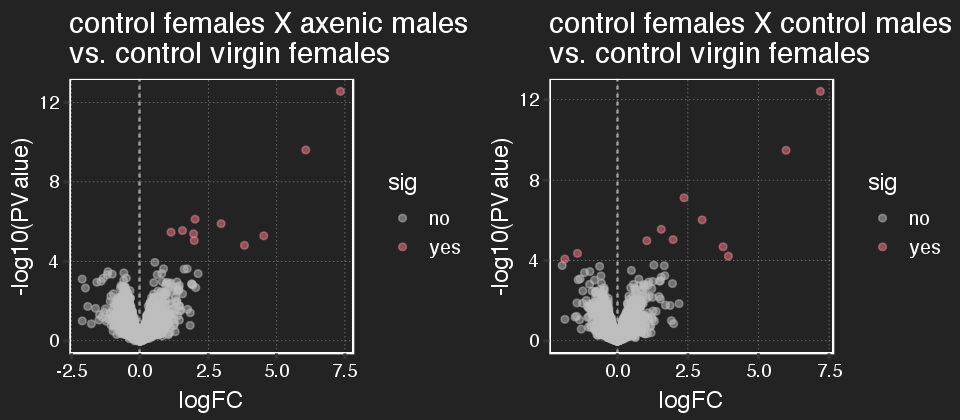

In [126]:
options(repr.plot.width = 8, repr.plot.height = 3.5)
# pdf("Figures/mated_control_female_contrasts.pdf", width = 8, height = 3.5)
plot_grid(CA.v.CO_contrasts_volcano.gg, CC.v.CO_contrasts_volcano.gg, ncol = 2)
# dev.off()

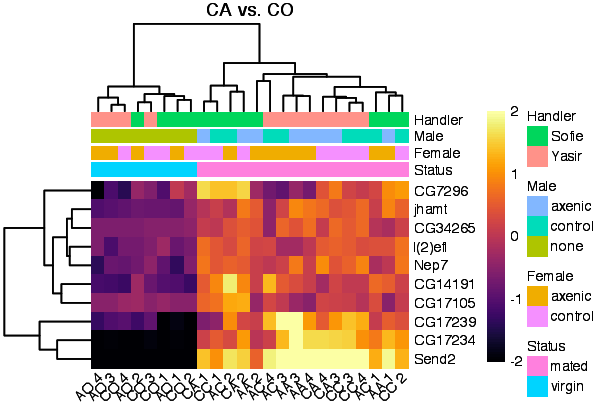

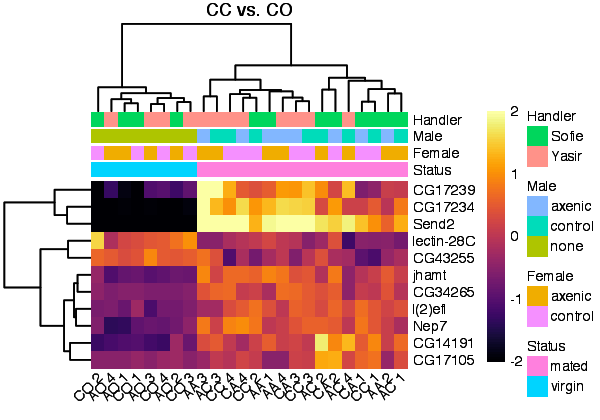

In [375]:
options(repr.plot.width = 5, repr.plot.height = 3.5)
heatmap_fa2(tpm_bt2, CA.v.CO_sigGenes, fly_atlas = F, title = "CA vs. CO")
heatmap_fa2(tpm_bt2, CC.v.CO_sigGenes, fly_atlas = F, title = "CC vs. CO")

We can now directly look at the overlap between the two contrasts:

                Length Class  Mode     
CC.v.CO         2      -none- character
CA.v.CO         1      -none- character
CC.v.CO,CA.v.CO 9      -none- character

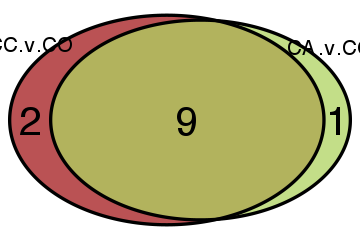

In [128]:
CCxCO.v.CAxCO_candidates <- list(CC.v.CO = CC.v.CO_sigGenes, 
                        CA.v.CO = CA.v.CO_sigGenes)

CCxCO.v.CAxCO_Vdiag<-venn.diagram(CCxCO.v.CAxCO_candidates, NULL, fill=c("#a3181b", "#afd360"), alpha=c(0.75,0.75), cex = 2, cat.fontface= 6, cat.cex = 1, resolution = 100, )

CCxCO.v.CAxCO_combs <- unlist(lapply(1:length(CCxCO.v.CAxCO_candidates), function(j) combn(names(CCxCO.v.CAxCO_candidates), j, simplify = FALSE)), recursive = FALSE)
names(CCxCO.v.CAxCO_combs) <- sapply(CCxCO.v.CAxCO_combs, function(i) paste0(i, collapse = ","))
CCxCO.v.CAxCO_elements <- lapply(CCxCO.v.CAxCO_combs, function(i) Setdiff(CCxCO.v.CAxCO_candidates[i], CCxCO.v.CAxCO_candidates[setdiff(names(CCxCO.v.CAxCO_candidates), i)]))
options(repr.plot.width = 3, repr.plot.height =2)
grid.arrange(gTree(children=CCxCO.v.CAxCO_Vdiag))
summary(CCxCO.v.CAxCO_elements)
rm(CCxCO.v.CAxCO_candidates, CCxCO.v.CAxCO_Vdiag, CCxCO.v.CAxCO_combs)

9 gene respond similarly to mating regardless of male genotype, but only 2 and 1 are unique to the CC and CA comparisons, respectively. For closer scrutiny we'll generate plots of individual genes:

In [131]:
tmp.Plots = suppressMessages(lapply(CCxCO.v.CAxCO_elements$`CC.v.CO,CA.v.CO`, geneBoxPlot_mon_byFemale, "axenic", show_reps = T))
ggsave("Results/Figures/CCxCO.v.CAxCO_elements_sigIn_sahred.Plots.pdf", marrangeGrob(grobs = tmp.Plots, nrow = 2, ncol =2))

tmp.Plots = suppressMessages(lapply(CCxCO.v.CAxCO_elements$CC.v.CO, geneBoxPlot_mon_byFemale, "axenic", show_reps = T))
ggsave("Results/Figures/CCxCO.v.CAxCO_elements_sigIn_CC.v.CO.Plots.pdf", marrangeGrob(grobs = tmp.Plots, nrow = 2, ncol =2))

tmp.Plots = suppressMessages(lapply(CCxCO.v.CAxCO_elements$CA.v.CO, geneBoxPlot_mon_byFemale, "axenic", show_reps = T))
ggsave("Results/Figures/CCxCO.v.CAxCO_elements_sigIn_CA.v.CO.Plots.pdf", marrangeGrob(grobs = tmp.Plots, nrow = 2, ncol =2))

rm(tmp.Plots)

Saving 7 x 7 in image
Saving 7 x 7 in image
Saving 7 x 7 in image


Run a GO analysis on the set of DE genes:

Set up null objects:

Using manually entered categories.
Calculating the p-values...
'select()' returned 1:1 mapping between keys and columns


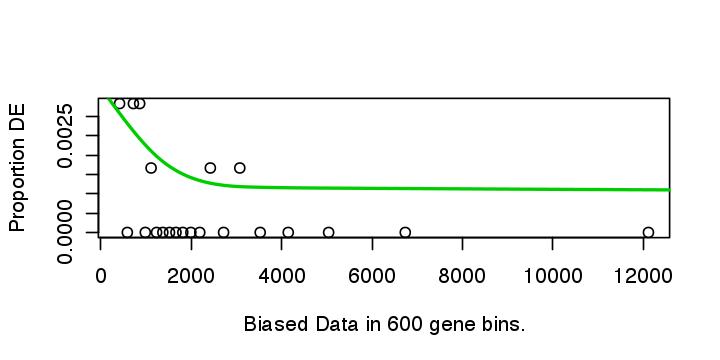

In [132]:
# build pwf based on ALL DE features
options(repr.plot.width = 6, repr.plot.height = 3)
cat_genes_vec = as.integer(features_with_GO %in% unlist(CCxCO.v.CAxCO_elements))
pwf=nullp(DEgenes = cat_genes_vec, bias.data=lengths_features_with_GO)
rownames(pwf) = names(GO_info_listed)
pwf$DEgenes = cat_genes_vec
res = goseq(pwf,gene2cat=GO_info_listed)

Run the multiple test correction and extract significant terms

In [133]:
## over-represented categories:
pvals = res$over_represented_pvalue
pvals[pvals > 1 -1e-10] = 1-1e-10
q = qvalue(pvals)
res$over_represented_FDR = q$qvalues
AAxAO.v.ACxAO_enrich_result_table = res[res$over_represented_pvalue<=0.05,]
subset(AAxAO.v.ACxAO_enrich_result_table, over_represented_FDR < 0.05)

category,over_represented_pvalue,under_represented_pvalue,numDEInCat,numInCat,term,ontology,over_represented_FDR


Let's make a point plot comparing the log fold-change between axenic and control females after mating to control males:

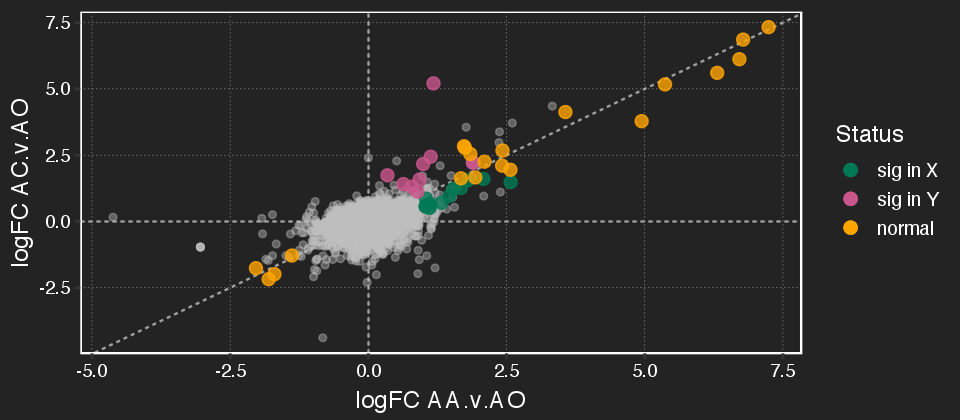

In [127]:
diag.plot(lrt.AA.v.AO.table, lrt.AC.v.AO.table) + theme_monokai_full() + theme(axis.text.x = element_text(angle = 0))

Using manually entered categories.
Calculating the p-values...
'select()' returned 1:1 mapping between keys and columns


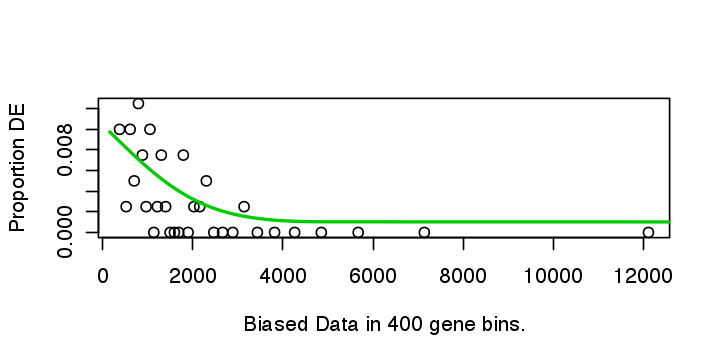

In [114]:
# build pwf based on ALL DE features
options(repr.plot.width = 6, repr.plot.height = 3)
cat_genes_vec = as.integer(features_with_GO %in% unlist(AAxAO.v.ACxAO_elements))
pwf=nullp(DEgenes = cat_genes_vec, bias.data=lengths_features_with_GO)
rownames(pwf) = names(GO_info_listed)
pwf$DEgenes = cat_genes_vec
res = goseq(pwf,gene2cat=GO_info_listed)

Run the multiple test correction and extract significant terms

In [119]:
## over-represented categories:
pvals = res$over_represented_pvalue
pvals[pvals > 1 -1e-10] = 1-1e-10
q = qvalue(pvals)
res$over_represented_FDR = q$qvalues
AAxAO.v.ACxAO_enrich_result_table = res[res$over_represented_pvalue<=0.05,]
subset(AAxAO.v.ACxAO_enrich_result_table, over_represented_FDR < 0.05)

,category,over_represented_pvalue,under_represented_pvalue,numDEInCat,numInCat,term,ontology,over_represented_FDR
6354,GO:0050830,1.300481e-09,1.0000000,7,56,defense response to Gram-positive bacterium,BP,1.041165e-05
3669,GO:0019731,2.565863e-08,1.0000000,5,22,antibacterial humoral response,BP,1.027115e-04
6353,GO:0050829,1.318163e-05,0.9999994,5,113,defense response to Gram-negative bacterium,BP,3.517736e-02


In [387]:
options(repr.plot.width = 4, repr.plot.height = 3.5)
AA.v.AO_x_AC.v.AO = diag.plot(lrt.AA.v.AO.table, lrt.AC.v.AO.table) + theme_monokai_full() + theme(axis.text.x = element_text(angle = 0))
CC.v.CO_x_CA.v.CO = diag.plot(lrt.CC.v.CO.table, lrt.CA.v.CO.table) + theme_monokai_full() + theme(axis.text.x = element_text(angle = 0))

Another approach is to generate K-means clusters of DE genes. We'll first extract the TPM matrix for DE geenes:

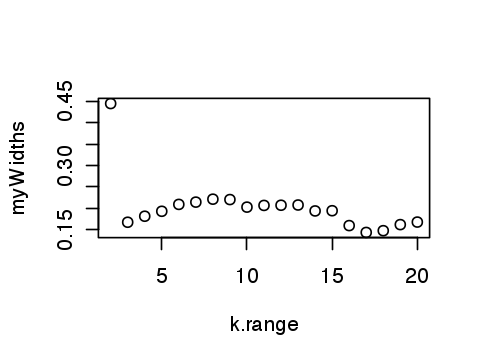

In [85]:
axenic_mated_DE_matrix = subset(tpm_bt2, rownames(tpm_bt2) %in% c(AA.v.AO_sigGenes, AC.v.AO_sigGenes, CA.v.CO_sigGenes, CC.v.CO_sigGenes))
options(repr.plot.width = 4, repr.plot.height = 3)
findK(axenic_mated_DE_matrix)

Now output all these plots:

In [137]:
t(do.call(rbind, CCxCO.v.CAxCO_elements) )

Warning message in rbind(...):
"number of columns of result is not a multiple of vector length (arg 1)"

CC.v.CO,CA.v.CO,"CC.v.CO,CA.v.CO"
FBgn0040099,FBgn0032283,FBgn0011296
FBgn0262900,FBgn0032283,FBgn0028841
FBgn0040099,FBgn0032283,FBgn0030981
FBgn0262900,FBgn0032283,FBgn0032280
FBgn0040099,FBgn0032283,FBgn0039564
FBgn0262900,FBgn0032283,FBgn0042186
FBgn0040099,FBgn0032283,FBgn0042187
FBgn0262900,FBgn0032283,FBgn0085294
FBgn0040099,FBgn0032283,FBgn0264253


In [118]:
options(repr.plot.width = 10, repr.plot.height = 3.5)
# pdf("Figures/logFC_pointPlots_allReps.pdf", width = 9, height = 7)
plot_grid(AA.v.AO_x_AC.v.AO, CC.v.CO_x_CA.v.CO, ncol = 2)
# dev.off()

ERROR: Error in plot_grid(AA.v.AO_x_AC.v.AO, CC.v.CO_x_CA.v.CO, ncol = 2): object 'AA.v.AO_x_AC.v.AO' not found


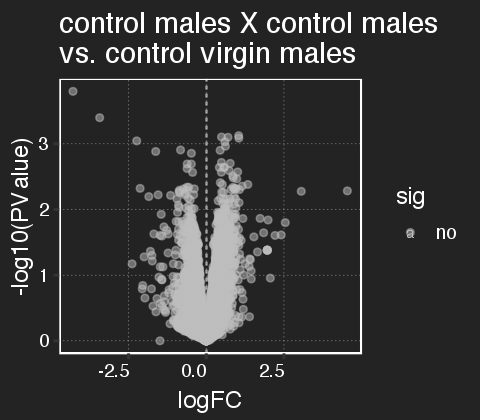

In [172]:
# run the LRT and extract the DE table
CC.effect.table <- edge.DE(dgeList_fit, CA.effect)
CC.effect_sigGenes = subset(CC.effect.table, sig == "yes")$gene

options(repr.plot.width = 4, repr.plot.height = 3.5)
CC.effect_contrasts_volcano.gg = edge.DE.gg(CC.effect.table) +
                                scale_colour_manual(values = c("gray","#f38195")) +
                                geom_text_repel(data = filter(CC.effect.table, sig == "yes" & -log10(PValue) > 5),aes(label=gene_symbol), 
                                force = 10,
                                fontface = "bold", 
                                size = 3) +
                                labs(title = "control males X control males\nvs. control virgin males", size = 2) +
                                theme_monokai_full() + theme(axis.text.x = element_text(angle = 0))
CC.effect_contrasts_volcano.gg

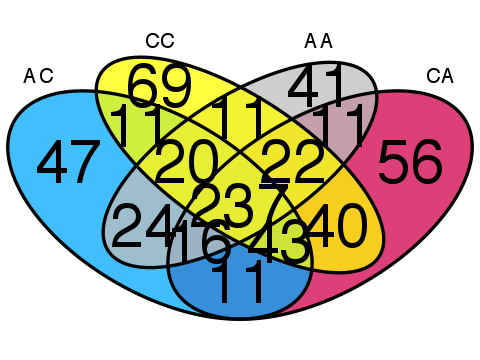

In [251]:
temp_candidates <- list(AC = AC_sigGenes, 
                        CA = CA_sigGenes, 
                        CC = CC_sigGenes,
                        AA = AA_sigGenes)

temp_Vdiag<-venn.diagram(temp_candidates, NULL, fill=c("#01aafb", "#d1004b", "yellow", "gray"), alpha=c(0.75,0.75,0.75, 0.75), cex = 3, cat.fontface= 6, cat.cex = 1, resolution = 100, )

options(repr.plot.width = 4, repr.plot.height =3)
grid.arrange(gTree(children=temp_Vdiag))
rm(temp_candidates, temp_Vdiag)

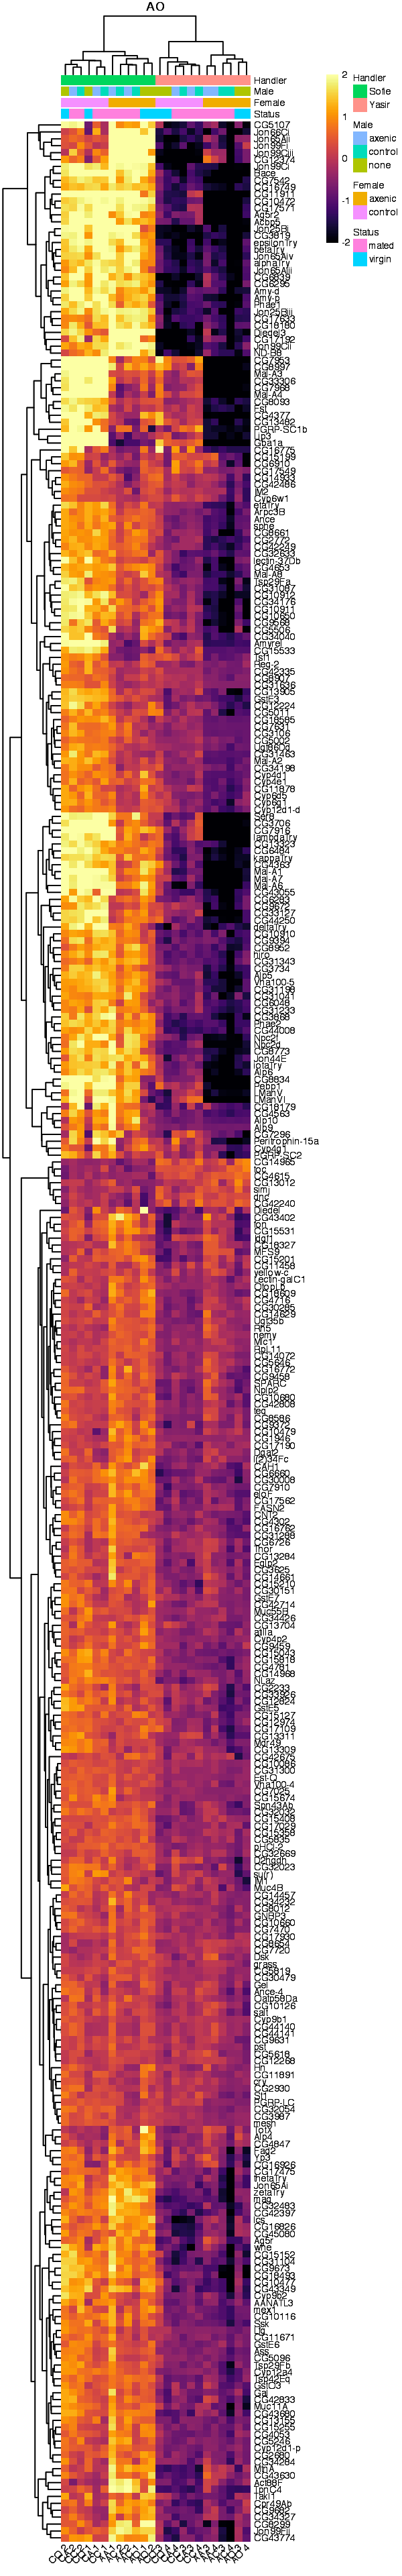

In [54]:
options(repr.plot.width = 5, repr.plot.height = 32)
heatmap_fa2(tpm_bt2, AO_sigGenes, fly_atlas = F, title = "AO")